# Coefficients Histogram Analysis

This notebook analyzes the distribution of pressure and Hilbert coefficients from the coefficients CSV file.

Features:
- Filter by time period
- Filter by variance reduction threshold
- Plot coefficient histograms for N, E, Z components
- Plot variance reduction distributions


In [1]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import os

# Set matplotlib style
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/home/andbro/anaconda3/envs/obs2/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/home/andbro/anaconda3/envs/obs2/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/traitlets/config/application.py", line 992, in la

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/home/andbro/anaconda3/envs/obs2/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/home/andbro/anaconda3/envs/obs2/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/traitlets/config/application.py", line 992, in la

AttributeError: _ARRAY_API not found

## Helper Functions


In [2]:
def check_dataframe_completeness(df):
    """
    Check if the dataframe has consistent sampling between start and end dates.
    
    Args:
        df: DataFrame with 'window_start' and 'window_end' columns
        
    Returns:
        dict: Contains start_date, end_date, expected_samples, actual_samples, 
              and completeness info
    """
    if df.empty:
        return {
            'start_date': None,
            'end_date': None,
            'expected_samples': 0,
            'actual_samples': 0,
            'is_complete': False,
            'missing_days': [],
            'samples_per_day': {}
        }
    
    # Get date range
    start_date = df['window_start'].min().date()
    end_date = df['window_end'].max().date()
    
    # Create date range
    date_range = pd.date_range(start=start_date, end=end_date, freq='D')
    
    # Count samples per day
    df['date'] = df['window_start'].dt.date
    samples_per_day = df.groupby('date').size().to_dict()
    
    # Calculate expected samples (assuming consistent sampling)
    # Find the most common number of samples per day
    if samples_per_day:
        sample_counts = list(samples_per_day.values())
        expected_samples_per_day = max(set(sample_counts), key=sample_counts.count)
        expected_total = expected_samples_per_day * len(date_range)
    else:
        expected_samples_per_day = 0
        expected_total = 0
    
    actual_samples = len(df)
    
    # Find missing days and days with wrong sample count
    missing_days = []
    for date in date_range:
        date_key = date.date()
        if date_key not in samples_per_day:
            missing_days.append(date_key)
        elif samples_per_day[date_key] != expected_samples_per_day:
            missing_days.append(date_key)
    
    is_complete = len(missing_days) == 0
    
    return {
        'start_date': start_date,
        'end_date': end_date,
        'expected_samples': expected_total,
        'actual_samples': actual_samples,
        'missing_samples': expected_total - actual_samples,
        'expected_samples_per_day': expected_samples_per_day,
        'is_complete': is_complete,
        'missing_days': missing_days,
        'samples_per_day': samples_per_day,
        'total_days': len(date_range),
        'total_missing_days': len(missing_days)
    }

In [3]:
def load_coefficients(filepath):
    """Load coefficients from CSV file."""
    if not os.path.exists(filepath):
        raise FileNotFoundError(f"Coefficients file not found: {filepath}")
    
    df = pd.read_csv(filepath)
    
    # Convert time columns to datetime
    df['window_start'] = pd.to_datetime(df['window_start'])
    df['window_end'] = pd.to_datetime(df['window_end'])
    
    # sort for window_start
    df = df.sort_values('window_start')

    # add relative time
    df['time_hours'] = (df['window_start'] - df['window_start'].iloc[0]).dt.total_seconds() / 3600

    return df

In [4]:
def filter_by_time_period(df, start_date, end_date):
    """Filter dataframe by time period."""
    if start_date:
        start_dt = pd.to_datetime(start_date)
        df = df[df['window_start'] >= start_dt]
    
    if end_date:
        end_dt = pd.to_datetime(end_date)
        df = df[df['window_end'] <= end_dt]
    
    return df

In [5]:
def filter_by_variance_reduction(df, threshold, components=['N', 'E', 'Z']):
    """Filter dataframe by variance reduction threshold."""
    if threshold is None:
        return df
    
    # Create a mask for rows that meet the threshold for at least one component
    mask = pd.Series([False] * len(df))
    
    for comp in components:
        var_red_col = f'var_red_{comp}'
        if var_red_col in df.columns:
            mask |= (df[var_red_col] >= threshold)
    
    return df[mask]

## Plotting Functions


In [6]:
def plot_coefficients_histogram(df, start_date=None, end_date=None, threshold=None, 
                               components=['N', 'E', 'Z'], figsize=(15, 10), 
                               alpha=0.7,  font=13, save_path=None):
    """
    Plot histograms of coefficients for specified time period.
    
    Args:
        df: DataFrame with coefficients data
        start_date: Start date filter (string or None)
        end_date: End date filter (string or None)
        threshold: Variance reduction threshold (float or None)
        components: List of components to plot ['N', 'E', 'Z']
        figsize: Figure size tuple
        font: 
        alpha: Transparency for histograms
        save_path: Path to save figure (optional)
    """
    from scipy.stats import gaussian_kde
    
    # Filter data
    df_filtered = filter_by_time_period(df, start_date, end_date)
    df_filtered = filter_by_variance_reduction(df_filtered, threshold, components)
    
    if len(df_filtered) == 0:
        print("No data found for the specified criteria.")
        return
    
    print(f"Plotting {len(df_filtered)} windows")
    if threshold:
        print(f"Variance reduction threshold: {threshold}%")
    
    # Create figure with subplots
    n_components = len(components)
    fig, axes = plt.subplots(n_components, 2, figsize=figsize, sharex='col')
    
    if n_components == 1:
        axes = axes.reshape(1, -1)
    
    colors = ['tab:blue', 'tab:orange', 'tab:red']
    
    bmin, bmax = -1000, 1000
    bins = np.arange(bmin, bmax, 20)

    # Plot histograms for each component
    for i, comp in enumerate(components):
        color = colors[i % len(colors)]
        
        # Pressure coefficients
        p_col = f'P_coef_{comp}'
        if p_col in df_filtered.columns:

            # filter for finite values
            p_data = df_filtered[p_col].dropna()

            # filter for bmin bmax range for the component
            p_data = p_data[(p_data >= bmin) & (p_data <= bmax)]

            if len(p_data) > 0:
                axes[i, 0].hist(p_data, bins=bins, alpha=alpha, color=color, 
                               label=f'P-{comp} (n={len(p_data)})', density=True)
                
                # Add KDE PDF
                kde_p = gaussian_kde(p_data)
                x_range = np.linspace(p_data.min(), p_data.max(), 500)
                kde_values = kde_p(x_range)
                axes[i, 0].plot(x_range, kde_values, color='black', linewidth=2)
                
                # Find and mark maximum
                max_idx = np.argmax(kde_values)
                max_x = x_range[max_idx]
                max_y = kde_values[max_idx]
                axes[i, 0].plot(max_x, max_y, 'kd', markersize=8, 
                               label=f'Max: {max_x:.0f} nrad/hPa', zorder=2)
                axes[i, 0].plot([max_x, max_x], [0, max_y], color='k', linestyle=':', alpha=0.7, zorder=2)
                
                # Add zero line
                axes[i, 0].axvline(0, color='gray', linestyle='--', linewidth=2, alpha=0.6)

                axes[i, 0].set_title(f'Pressure Coefficients - {comp} Component', fontsize=font)
                axes[i, 0].set_xlabel('Coefficient (nrad/hPa)', fontsize=font)
                axes[i, 0].set_ylabel('Density', fontsize=font)
                axes[i, 0].grid(True, alpha=0.3)
                axes[i, 0].legend(fontsize=font-1)
                axes[i, 0].set_xlim(bins.min(), bins.max())

        # Hilbert coefficients
        h_col = f'H_coef_{comp}'
        if h_col in df_filtered.columns:
            # filter for finite values
            h_data = df_filtered[h_col].dropna()

            # filter for bmin bmax range for the component
            h_data = h_data[(h_data >= bmin) & (h_data <= bmax)]

            if len(h_data) > 0:
                axes[i, 1].hist(h_data, bins=bins, alpha=alpha, color=color, zorder=2, 
                               label=f'H-{comp} (n={len(h_data)})', density=True)
                
                # Add KDE PDF
                kde_h = gaussian_kde(h_data)
                x_range = np.linspace(h_data.min(), h_data.max(), 500)
                kde_values = kde_h(x_range)
                axes[i, 1].plot(x_range, kde_values, color='black', linewidth=2)
                
                # Find and mark maximum
                max_idx = np.argmax(kde_values)
                max_x = x_range[max_idx]
                max_y = kde_values[max_idx]
                axes[i, 1].plot(max_x, max_y, 'kd', markersize=8, 
                               label=f'Max: {max_x:.0f} nrad/hPa', zorder=2)
                axes[i, 1].plot([max_x, max_x], [0, max_y], color='k', linestyle=':', alpha=0.7, zorder=2)
                
                # Add zero line
                axes[i, 1].axvline(0, color='gray', linestyle='--', linewidth=2, alpha=0.6, zorder=1)
                
                axes[i, 1].set_title(f'Hilbert Coefficients - {comp} Component', fontsize=font)
                axes[i, 1].set_xlabel('Coefficient (nrad/hPa)', fontsize=font)
                axes[i, 1].set_ylabel('Density', fontsize=font)
                axes[i, 1].grid(True, alpha=0.3)
                axes[i, 1].legend(fontsize=font-1)
                axes[i, 1].set_xlim(bins.min(), bins.max())

    # Set overall title
    title_parts = []
    if start_date:
        title_parts.append(f"From: {start_date}")
    if end_date:
        title_parts.append(f"To: {end_date}")
    if threshold:
        title_parts.append(f"VR ≥ {threshold}%")
    
    title = "Coefficients Statistics"
    if title_parts:
        title += f" ({', '.join(title_parts)})"
    
    fig.suptitle(title, fontsize=font+1)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Figure saved to: {save_path}")
    
    plt.show()

## Load Data


In [ ]:
station = "DROMY" # "ROMY" or "FUR" or "DROMY"

# Load coefficients data
if station == "ROMY":
    filepath = './output/coefficients_romy/coefficients_v2.csv'
elif station == "FUR":
    filepath = './output/coefficients_fur/coefficients_v2.csv'
elif station == "DROMY":
    filepath = './output/coefficients_dromy/coefficients_v2.csv'
    
try:
    df = load_coefficients(filepath)
    print(f"Loaded {len(df)} windows")
    print(f"Date range: {df['window_start'].min()} to {df['window_end'].max()}")
    print(f"Columns: {list(df.columns)}")
except FileNotFoundError as e:
    print(f"Error: {e}")
    print("Please update the filepath variable with the correct path to your coefficients file.")

completeness_info = check_dataframe_completeness(df)

print("\nData Completeness Check:")
print(f"Start Date: {completeness_info['start_date']}")
print(f"End Date: {completeness_info['end_date']}")
print(f"Total Days: {completeness_info['total_days']}")
print(f"Total Missing Days: {completeness_info['total_missing_days']}")
print(f"Expected Samples: {completeness_info['expected_samples']}")
print(f"Actual Samples: {completeness_info['actual_samples']}")
print(f"Missing Samples: {completeness_info['expected_samples'] - completeness_info['actual_samples']}")
print(f"Expected Samples per Day: {completeness_info['expected_samples_per_day']}")
print(f"Is Complete: {completeness_info['is_complete']}")

Loaded 4895 windows
Date range: 2024-03-01 00:00:00 to 2025-01-01 00:00:00
Columns: ['window_start', 'window_end', 'P_coef_N', 'H_coef_N', 'var_red_N', 'P_coef_E', 'H_coef_E', 'var_red_E', 'P_coef_Z', 'H_coef_Z', 'var_red_Z', 'cc_zero_N_P', 'cc_max_N_P', 'cc_lag_N_P', 'cc_zero_N_H', 'cc_max_N_H', 'cc_lag_N_H', 'cc_zero_E_P', 'cc_max_E_P', 'cc_lag_E_P', 'cc_zero_E_H', 'cc_max_E_H', 'cc_lag_E_H', 'cc_zero_Z_P', 'cc_max_Z_P', 'cc_lag_Z_P', 'cc_zero_Z_H', 'cc_max_Z_H', 'cc_lag_Z_H', 'time_hours']

Data Completeness Check:
Start Date: 2024-03-01
End Date: 2025-01-01
Total Days: 307
Total Missing Days: 2
Expected Samples: 4912
Actual Samples: 4895
Missing Samples: 17
Expected Samples per Day: 16
Is Complete: False


## Basic Analysis


In [8]:
# Show first few rows
df.head()

# a list with all coef column names
names = [col for col in df.columns if col.startswith('coef_')]

# multiply all columns with factor
for col in df.columns:
    if "coef" in col:
        df[col] *= 1e11

## Plot Coefficients Histograms


/tmp/ipykernel_322749/3927054842.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return df[mask]


Plotting 217 windows
Variance reduction threshold: 70%


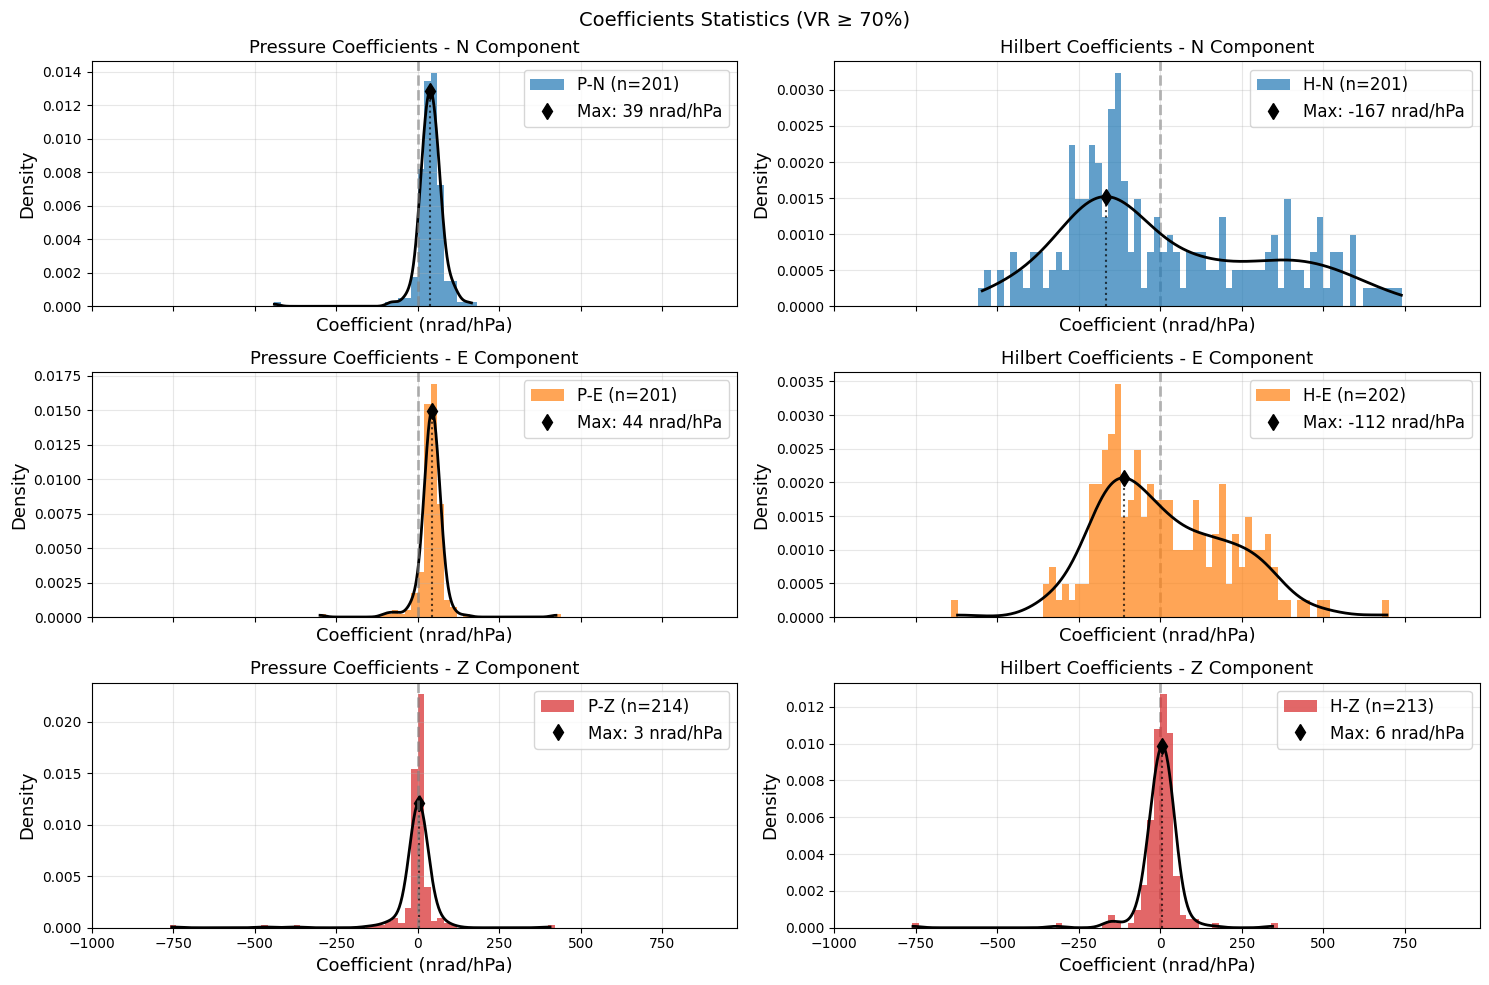

In [9]:
# Custom parameters - modify these as needed
start_date = None  # e.g., '2024-03-01'
end_date = None    # e.g., '2024-03-31'
threshold = 70   # e.g., 50
components = ['N', 'E', 'Z']  # Components to analyze

# Create custom plot
plot_coefficients_histogram(df, start_date=start_date, end_date=end_date, 
                           threshold=threshold, components=components)


In [10]:
def plot_coefficients_statistics(df, vr_threshold=50, absolute=False, figsize=(15, 13), bin_paras = {}, save_path=None, show_kde=False):
    """
    Create comprehensive statistics plot replicating ROMY model analysis exactly.
    
    Args:
        df: DataFrame with coefficients data
        vr_threshold: Variance reduction threshold for filtering (default: 50%)
        absolute: If True, show absolute values of coefficients (default: False)
        figsize: Figure size tuple
        save_path: Path to save figure (optional)
        show_kde: If True, show KDE for high VR data (default: False)
    """
    
    if len(df) == 0:
        print("No data found.")
        return
    
    import matplotlib.pyplot as plt
    import numpy as np
    import yaml
    from matplotlib.gridspec import GridSpec
    from scipy.stats import gaussian_kde
    
    model = {}

    # if show_kde:
    #     density = True
    #     hist_y_label = "Density"
    # else:
    #     density = False
    #     hist_y_label = "Count"
    density=False
    hist_y_label = "count"

    # Set up colors exactly like ROMY
    colors = {"Z": "tab:green", "N": "tab:red", "E": "tab:blue"}
    
    Nrow, Ncol = 4, 2  # 4 rows, 2 columns
    font = 12
    ms1, ms2 = 5, 20  # marker sizes
    scale, unit = 1, "nrad/hPa"
    
    # Filter data with high VR
    dfN = df[df['var_red_N'] > vr_threshold]
    dfE = df[df['var_red_E'] > vr_threshold]
    dfZ = df[df['var_red_Z'] > vr_threshold]
    
    # Create figure and grid
    fig = plt.figure(figsize=figsize)
    gs = GridSpec(Nrow, Ncol, figure=fig, hspace=0.25)
    
    # Create all subplots
    axes = []
    for i in range(Nrow):
        for j in range(Ncol):
            axes.append(fig.add_subplot(gs[i, j]))
    
    # Row 1: (a) and (b) - Scatter plots
    # Left plot (a) - scatter of coefficients P
    ax0 = axes[0]
    
    # Apply absolute transformation if requested
    p_z_data = np.abs(df['P_coef_Z'])
    p_n_data = np.abs(df['P_coef_N'])
    p_e_data = np.abs(df['P_coef_E'])
    
    ax0.scatter(df['var_red_Z'], p_z_data*scale, s=ms1, color=colors["Z"], 
                label=r"a$_Z$", zorder=2, alpha=0.5)
    ax0.scatter(df['var_red_N'], p_n_data*scale, s=ms1, color=colors["N"], 
                label=r"a$_N$", zorder=2, alpha=0.5)
    ax0.scatter(df['var_red_E'], p_e_data*scale, s=ms1, color=colors["E"], 
                label=r"a$_E$", zorder=2, alpha=0.5)
    
    # High VR data
    p_z_high = np.abs(dfZ['P_coef_Z'])
    p_n_high = np.abs(dfN['P_coef_N'])
    p_e_high = np.abs(dfE['P_coef_E'])
    
    ax0.scatter(dfZ['var_red_Z'], p_z_high*scale, s=ms2, color=colors["Z"], 
                zorder=2, edgecolor="k", alpha=0.8)
    ax0.scatter(dfN['var_red_N'], p_n_high*scale, s=ms2, color=colors["N"], 
                zorder=2, edgecolor="k", alpha=0.8)
    ax0.scatter(dfE['var_red_E'], p_e_high*scale, s=ms2, color=colors["E"], 
                zorder=2, edgecolor="k", alpha=0.8)
    
    ax0.legend(loc='lower right', fontsize=font-2, markerscale=2)
    ax0.set_yscale("log")
    ax0.set_xlim(0, 100)
    ax0.set_xlabel("variance reduction (%)", fontsize=font)
    ax0.set_ylabel(f"coefficient a ({unit})", fontsize=font)
    ax0.set_ylim(1e-1, 6e3)
    ax0.grid(ls="--", alpha=0.4, zorder=0)
    
    # Add VR threshold line for subplot (a)
    ax0.axvline(x=vr_threshold, color='gray', linestyle='--', alpha=0.8, linewidth=2, zorder=1)
    
    # Right plot (b) - scatter of coefficients H[P]
    ax1 = axes[1]
    
    # Apply absolute transformation if requested
    h_z_data = np.abs(df['H_coef_Z'])
    h_n_data = np.abs(df['H_coef_N'])
    h_e_data = np.abs(df['H_coef_E'])
    
    ax1.scatter(df['var_red_Z'], h_z_data*scale, s=ms1, color=colors["Z"], 
                label=r"b$_Z$", zorder=2, alpha=0.7)
    ax1.scatter(df['var_red_N'], h_n_data*scale, s=ms1, color=colors["N"], 
                label=r"b$_N$", zorder=2, alpha=0.7)
    ax1.scatter(df['var_red_E'], h_e_data*scale, s=ms1, color=colors["E"], 
                label=r"b$_E$", zorder=2, alpha=0.7)
    
    # High VR data
    h_z_high = np.abs(dfZ['H_coef_Z'])
    h_n_high = np.abs(dfN['H_coef_N'])
    h_e_high = np.abs(dfE['H_coef_E'])
    
    ax1.scatter(dfZ['var_red_Z'], h_z_high*scale, s=ms2, color=colors["Z"], 
                zorder=2, edgecolor="k", alpha=0.8)
    ax1.scatter(dfN['var_red_N'], h_n_high*scale, s=ms2, color=colors["N"], 
                zorder=2, edgecolor="k", alpha=0.8)
    ax1.scatter(dfE['var_red_E'], h_e_high*scale, s=ms2, color=colors["E"], 
                zorder=2, edgecolor="k", alpha=0.8)
    ax1.legend(loc='lower right', fontsize=font-2, markerscale=2)
    ax1.set_yscale("log")
    ax1.set_xlim(0, 100)
    ax1.set_xlabel("variance reduction (%)", fontsize=font)
    ax1.set_ylabel(f"coefficient b ({unit})", fontsize=font)
    ax1.set_ylim(1e-1, 6e3)
    ax1.grid(ls="--", alpha=0.4, zorder=0)
    
    # Add VR threshold line for subplot (b)
    ax1.axvline(x=vr_threshold, color='gray', linestyle='--', alpha=0.8, linewidth=2, zorder=1)
    
    # Row 2: (c) and (d) - Histograms of coefficient 'a' for N and E
    alpha_all = 0.3
    alpha_high = 0.8
    bin_step = bin_paras['bin_step'] #20
    bmin, bmax = bin_paras['bmin'], bin_paras['bmax'] # -700, 700
    bins = np.arange(bmin, bmax+bin_step, bin_step)
    
    for idx, comp in enumerate(['N', 'E']):
        ax = axes[2 + idx]
        
        # P coefficients - apply absolute if requested
        all_data = df[f'P_coef_{comp}']*scale
        high_vr_data = locals()[f'df{comp}'][f'P_coef_{comp}']*scale
        
        if absolute:
            all_data = np.abs(all_data)
            high_vr_data = np.abs(high_vr_data)
            # Adjust bin range for absolute values
            bmin_abs, bmax_abs = 0, bmax
            bins_abs = np.arange(bmin_abs, bmax_abs+bin_step, bin_step)
            ax.hist(all_data, bins=bins_abs, range=(bmin_abs, bmax_abs),
                    alpha=alpha_all, color=colors[comp], 
                    label=f'All data (n={len(all_data)})', zorder=1, density=density)
            if bin_paras['bin_step'] < 1:
                ax.hist(high_vr_data, bins=bins_abs, range=(bmin_abs, bmax_abs),
                        alpha=alpha_high, color=colors[comp], 
                        label=f'VR > {vr_threshold}% (n={len(high_vr_data)})', 
                        zorder=2, density=density)
            else:
                ax.hist(high_vr_data, bins=bins_abs, range=(bmin_abs, bmax_abs),
                        alpha=alpha_high, color=colors[comp], 
                        label=f'VR > {vr_threshold}% (n={len(high_vr_data)})', 
                        zorder=2, edgecolor='k', density=density)

            ax.set_xlim(bmin_abs, bmax_abs)
        else:
            ax.hist(all_data, bins=bins, range=(bmin, bmax),
                    alpha=alpha_all, color=colors[comp], 
                    label=f'All data (n={len(all_data)})', zorder=1, density=density)
            if bin_paras['bin_step'] < 1:
                ax.hist(high_vr_data, bins=bins, range=(bmin, bmax),
                        alpha=alpha_high, color=colors[comp], 
                        label=f'VR > {vr_threshold}% (n={len(high_vr_data)})', 
                        zorder=2, density=density)
            else:
                ax.hist(high_vr_data, bins=bins, range=(bmin, bmax),
                        alpha=alpha_high, color=colors[comp], 
                        label=f'VR > {vr_threshold}% (n={len(high_vr_data)})', 
                        zorder=2, edgecolor='k', density=density)
            ax.set_xlim(bmin, bmax)
        
        # Add KDE for all data with proper validation
        if show_kde:
            # Clean data: remove NaN and infinite values
            if absolute:
                high_vr_data_clean = high_vr_data.abs().dropna()
            else:
                high_vr_data_clean = high_vr_data.dropna()

            # filter for bmin bmax range for the component
            high_vr_data_clean = high_vr_data_clean[(high_vr_data_clean >= bmin) & (high_vr_data_clean <= bmax)]

            # filter for finite values
            high_vr_data_clean = high_vr_data_clean[np.isfinite(high_vr_data_clean)]
            
            if len(high_vr_data_clean) > 1 and not high_vr_data_clean.empty:
                try:
                    kde = gaussian_kde(high_vr_data_clean)
                    x_range = np.arange(bmin, bmax, bin_step/10)
                    kde_values = kde(x_range)
                    kde_values = kde_values*np.sum(abs(x_range))*bin_step/abs(bmax-bmin)

                    ax.plot(x_range, kde_values, color='black', linewidth=1.5, alpha=0.8, zorder=3)

                    # Find and mark maximum
                    max_idx = np.argmax(kde_values)
                    max_x = x_range[max_idx]
                    max_y = kde_values[max_idx]
                    mad = np.median(abs(high_vr_data_clean - max_x))

                    ax.plot(max_x, max_y, 'kd', markersize=6, zorder=4, label=f"Max: {max_x:.2f} $\pm$ {mad:.2f} {unit}", markerfacecolor='white')
                    ax.plot([max_x, max_x], [0, max_y], color='black', linestyle=':', alpha=0.7, zorder=3)

                    # add uncertainty band
                    ax.plot([max_x-mad, max_x+mad], [max_y, max_y], color='gray', linestyle='-', alpha=0.9, zorder=3)

                    model[comp] = {
                        "coeff_P": round(float(max_x), 1),
                        "coeff_P_mad": round(float(mad), 1)
                    }

                except (ValueError, np.linalg.LinAlgError):
                    # Skip KDE if it fails (e.g., singular matrix, insufficient data)
                    pass
        
        ax.legend(loc='upper right', fontsize=font-2)
        ax.grid(ls="--", alpha=0.4, zorder=0)
        ax.set_xlabel(f"coefficient a$_{comp}$ ({unit})", fontsize=font)
        ax.set_ylabel(hist_y_label, fontsize=font)
        ax.set_ylim(0, None)  # Let y-axis auto-scale
    
    # Row 3: (e) and (f) - Histograms of coefficient 'b' for N and E
    for idx, comp in enumerate(['N', 'E']):
        ax = axes[4 + idx]

        # H[P] coefficients - apply absolute if requested
        all_data = df[f'H_coef_{comp}']*scale
        high_vr_data = locals()[f'df{comp}'][f'H_coef_{comp}']*scale
        
        if absolute:
            all_data = np.abs(all_data)
            high_vr_data = np.abs(high_vr_data)
            # Adjust bin range for absolute values
            bmin_abs, bmax_abs = 0, bmax
            bins_abs = np.arange(bmin_abs, bmax_abs+bin_step, bin_step)
            ax.hist(all_data, bins=bins_abs, range=(bmin_abs, bmax_abs),
                    alpha=alpha_all, color=colors[comp], 
                    label=f'All data (n={len(all_data)})', zorder=1, density=density)
            if bin_paras['bin_step'] < 1:
                ax.hist(high_vr_data, bins=bins_abs, range=(bmin_abs, bmax_abs),
                        alpha=alpha_high, color=colors[comp], 
                        label=f'VR > {vr_threshold}% (n={len(high_vr_data)})', 
                        zorder=2, density=density)
            else:
                ax.hist(high_vr_data, bins=bins_abs, range=(bmin_abs, bmax_abs),
                        alpha=alpha_high, color=colors[comp], 
                        label=f'VR > {vr_threshold}% (n={len(high_vr_data)})', 
                        zorder=2, edgecolor='k', density=density)
            ax.set_xlim(bmin_abs, bmax_abs)
        else:
            ax.hist(all_data, bins=bins, range=(bmin, bmax),
                    alpha=alpha_all, color=colors[comp], 
                    label=f'All data (n={len(all_data)})', zorder=1, density=density)
            if bin_paras['bin_step'] < 1:
                ax.hist(high_vr_data, bins=bins, range=(bmin, bmax),
                        alpha=alpha_high, color=colors[comp], 
                        label=f'VR > {vr_threshold}% (n={len(high_vr_data)})', 
                        zorder=2, density=density)
            else:
                ax.hist(high_vr_data, bins=bins, range=(bmin, bmax),
                        alpha=alpha_high, color=colors[comp], 
                        label=f'VR > {vr_threshold}% (n={len(high_vr_data)})', 
                        zorder=2, edgecolor='k', density=density)
            ax.set_xlim(bmin, bmax)
        
        # Add KDE for all data with proper validation
        if show_kde:
            # Clean data: remove NaN and infinite values
            if absolute:
                high_vr_data_clean = high_vr_data.abs().dropna()
            else:
                high_vr_data_clean = high_vr_data.dropna()

            # filter for bmin bmax range for the component
            high_vr_data_clean = high_vr_data_clean[(high_vr_data_clean >= bmin) & (high_vr_data_clean <= bmax)]
            
            # filter for finite values
            high_vr_data_clean = high_vr_data_clean[np.isfinite(high_vr_data_clean)]

            if len(high_vr_data_clean) > 1 and not high_vr_data_clean.empty:
                try:
                    kde = gaussian_kde(high_vr_data_clean)
                    x_range = np.arange(bmin, bmax, bin_step/100)
                    kde_values = kde(x_range)
                    kde_values = kde_values*np.sum(abs(x_range))*bin_step/10/abs(bmax-bmin)
                   
                    ax.plot(x_range, kde_values, color='black', linewidth=1.5, alpha=0.8, zorder=3)
                    
                    # Find and mark maximum
                    max_idx = np.argmax(kde_values)
                    max_x = x_range[max_idx]
                    max_y = kde_values[max_idx]
                    mad = np.median(abs(high_vr_data_clean - max_x))

                    ax.plot(max_x, max_y, 'kd', markersize=6, zorder=4, label=f"Max: {max_x:.2f} $\pm$ {mad:.2f} {unit}", markerfacecolor='white')
                    ax.plot([max_x, max_x], [0, max_y], color='black', linestyle=':', alpha=0.7, zorder=3)
                    
                    # add uncertainty band
                    ax.plot([max_x-mad, max_x+mad], [max_y, max_y], color='gray', linestyle='-', alpha=0.8, zorder=3)

                    model[comp].update({
                        "coeff_H": round(float(max_x), 1),
                        "coeff_H_mad": round(float(mad), 1)
                    })
                except (ValueError, np.linalg.LinAlgError):
                    # Skip KDE if it fails (e.g., singular matrix, insufficient data)
                    pass
        
        ax.legend(loc='upper right', fontsize=font-2)
        ax.grid(ls="--", alpha=0.4, zorder=0)
        ax.set_xlabel(f"coefficient b$_{comp}$ ({unit})", fontsize=font)
        ax.set_ylabel(hist_y_label, fontsize=font)
        ax.set_ylim(0, None)  # Let y-axis auto-scale
    
    # Row 4: (g) and (h) - Box plot and VR distribution
    # Left plot (g) - boxplot
    ax6 = axes[6]
    a_z, a_n, a_e = dfZ['P_coef_Z']*scale, dfN['P_coef_N']*scale, dfE['P_coef_E']*scale
    b_z, b_n, b_e = dfZ['H_coef_Z']*scale, dfN['H_coef_N']*scale, dfE['H_coef_E']*scale
    
    if absolute:
        a_z, a_n, a_e = np.abs(a_z), np.abs(a_n), np.abs(a_e)
        b_z, b_n, b_e = np.abs(b_z), np.abs(b_n), np.abs(b_e)

        # Adjust y-axis limits for absolute values
        ax6.set_ylim(0, bmax)
    else:
        ax6.set_ylim(bmin, bmax)
    
    arr = [a_z, a_n, a_e, b_z, b_n, b_e]
    bp = ax6.boxplot(arr, showmeans=False)
    
    # Get medians for labels
    meds = {}
    for i, label in enumerate(['a_z', 'a_n', 'a_e', 'b_z', 'b_n', 'b_e']):
        meds[label] = bp['medians'][i].get_ydata()[1]
    
    lbls = [f"a$_Z$ \n (={int(meds['a_z'])})", f"a$_N$ \n (={int(meds['a_n'])})", f"a$_E$ \n (={int(meds['a_e'])})",
            f"b$_Z$ \n (={int(meds['b_z'])})", f"b$_N$ \n (={int(meds['b_n'])})", f"b$_E$ \n (={int(meds['b_e'])})"]
    ax6.set_xticklabels(lbls, fontsize=font)
    ax6.set_ylabel(f"coefficient ({unit})", fontsize=font)
    ax6.grid(ls="--", alpha=0.4, zorder=0)
    
    # Right plot (h) - variance reduction histogram
    ax7 = axes[7]
    Nmax = df.shape[0]
    weights = [np.ones(Nmax)/Nmax*100, np.ones(Nmax)/Nmax*100, np.ones(Nmax)/Nmax*100]
    ax7.hist([df['var_red_N'], df['var_red_E'], df['var_red_Z']], bins=10, range=[0, 100], alpha=0.8,
             density=False, weights=weights,
             rwidth=0.8, align="mid", zorder=2, edgecolor="k",
             color=[colors["N"], colors["E"], colors["Z"]], label=["N", "E", "Z"])

    ax7.grid(alpha=0.2, ls="--", zorder=0)
    ax7.set_xlim(0, 100)
    ax7.legend(loc='upper right', fontsize=font-2)
    ax7.set_xlabel("variance reduction (%)", fontsize=font)
    ax7.set_ylabel("data periods (%)", fontsize=font)
    ax7.set_ylim(0, 50)
    
    # Add VR threshold line for subplot (h)
    ax7.axvline(x=vr_threshold, color='gray', linestyle='--', alpha=0.8, linewidth=2, zorder=1)
    
    # Add subplot labels
    for i, ax in enumerate(axes):
        ax.text(.015, .95, f"({chr(97+i)})", ha='left', va='top', 
                transform=ax.transAxes, fontsize=font+2, 
                bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
        ax.grid(ls="--", alpha=0.4, zorder=0)
        ax.minorticks_on()
    
    # Add supertitle
    text = f"{station} Statistics of Barometric Model:"
    fig.suptitle(text + r" $\theta_i$ = $a_i$ $\cdot$ P + $b_i$ $\cdot$ H[P]", fontsize=font+1, y=0.91)
    
    plt.tight_layout()
    plt.show()

    # write model to yaml
    with open(f'./data/statsmodel_{station}.yaml', 'w') as f:
        yaml.dump(model, f)

    return fig

/tmp/ipykernel_322749/1417426442.py:388: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


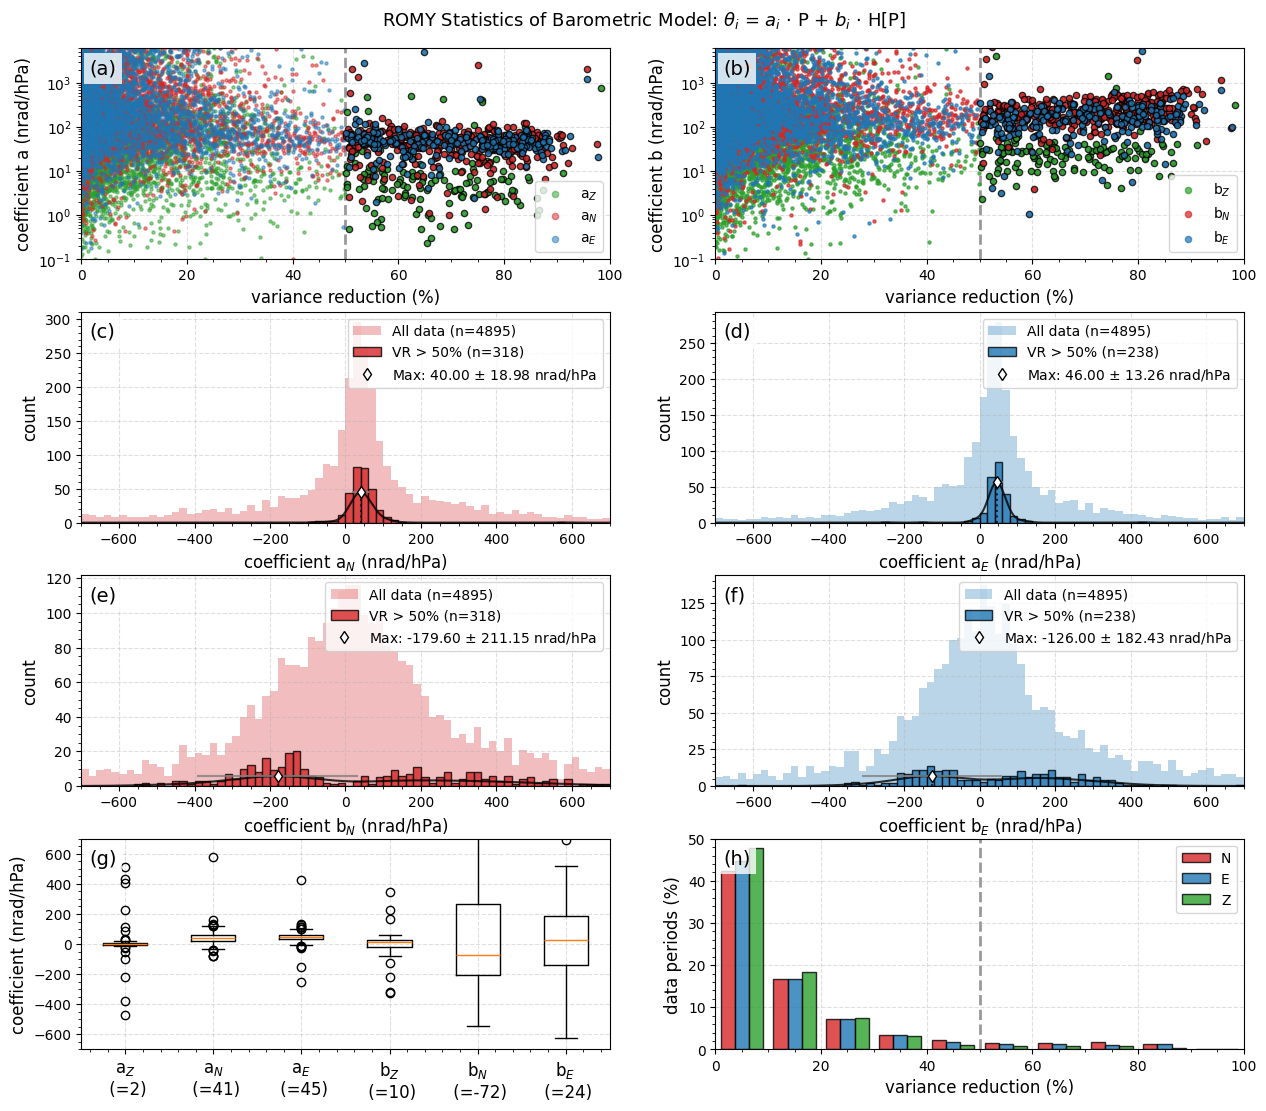

In [11]:
if station == "FUR":
    fig = plot_coefficients_statistics(
        df, 
        vr_threshold=50, 
        bin_paras={'bin_step': 1, 'bmin': -75, 'bmax': 75}, 
        show_kde=True
    )
elif station == "ROMY":
    fig = plot_coefficients_statistics(
        df, 
        vr_threshold=50, 
        bin_paras={'bin_step': 20, 'bmin': -700, 'bmax': 700}, 
        show_kde=True
    )
elif station == "DROMY":
    fig = plot_coefficients_statistics(
        df, 
        vr_threshold=40, 
        bin_paras={'bin_step': 2, 'bmin': -150, 'bmax': 150}, 
        show_kde=True
    )

fig.savefig(f'figures/{station}_model_coefficients_statistics.png', dpi=150, bbox_inches='tight')

/tmp/ipykernel_322749/1417426442.py:388: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


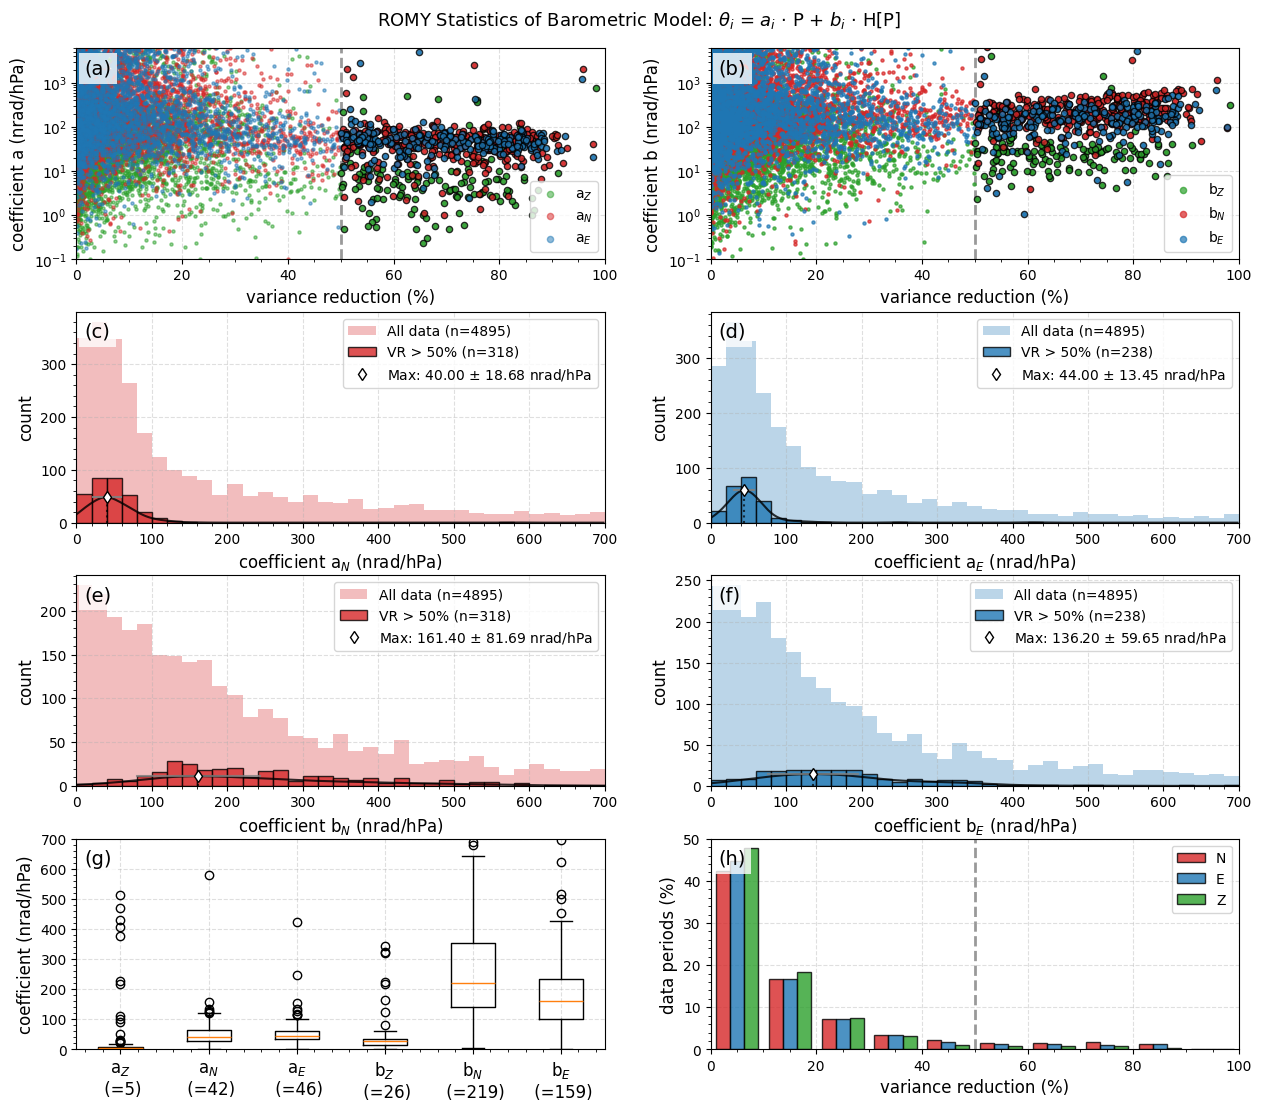

In [12]:
if station == "FUR":
    fig = plot_coefficients_statistics(
        df, 
        vr_threshold=50, 
        absolute=True,
        bin_paras={'bin_step': 1, 'bmin': -75, 'bmax': 75}, 
        show_kde=True
    )
elif station == "ROMY": 
    fig = plot_coefficients_statistics(
        df, 
        vr_threshold=50,
        absolute=True,
        bin_paras={'bin_step': 20, 'bmin': -700, 'bmax': 700}, 
        show_kde=True
    )
elif station == "DROMY":
    fig = plot_coefficients_statistics(
        df, 
        vr_threshold=40, 
        absolute=True,
        bin_paras={'bin_step': 2, 'bmin': -150, 'bmax': 150}, 
        show_kde=True
    )

fig.savefig(f'figures/{station}_model_coefficients_statistics_abs.png', dpi=150, bbox_inches='tight')

### Correlation vs. Variance Reduction

In [13]:
def plot_variance_vs_cc(df, components=['N', 'E', 'Z'], cc_type="zero", save_path=None):
    """
    Plot variance reduction vs cross-correlation coefficients for each component.
    
    Args:
        df: DataFrame with coefficients data
        components: List of components to plot ['N', 'E', 'Z']
        cc_type: Type of cross-correlation to plot, either "zero" or "max"
        save_path: Path to save figure (optional)
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Setup
    fig, axes = plt.subplots(1, len(components), figsize=(18, 6))
    if len(components) == 1:
        axes = [axes]
    
    # Components and their colors
    colors = {"Z": "tab:green", "N": "tab:red", "E": "tab:blue"}
    colors2 = {"Z": "darkgreen", "N": "darkred", "E": "darkblue"}

    # Plot parameters
    font = 14
    ms1, ms2 = 30, 50  # marker sizes
    alpha = 0.6
    
    for idx, comp in enumerate(components):
        ax = axes[idx]
        
        # Get data for this component
        var_red = df[f'var_red_{comp}']
        if cc_type == "zero":
            cc_pp = df[f'cc_zero_{comp}_P']  # Cross-correlation with pressure
            cc_hp = df[f'cc_zero_{comp}_H']  # Cross-correlation with Hilbert
        elif cc_type == "max":
            cc_pp = df[f'cc_max_{comp}_P']  # Cross-correlation with pressure
            cc_hp = df[f'cc_max_{comp}_H']  # Cross-correlation with Hilbert
        
        # Create scatter plots
        ax.scatter(var_red, cc_pp, 
                  label='P', 
                  color=colors[comp],
                  s=ms1,
                  alpha=alpha,
                  marker='o')
        
        ax.scatter(var_red, cc_hp,
                  label='H[P]',
                  color=colors2[comp],
                  s=ms1,
                  alpha=alpha,
                  marker='^')
        
        # Styling
        ax.set_xlabel('Variance Reduction (%)', fontsize=font)
        if cc_type == "zero":
            ax.set_ylabel('Zero-Lag Cross-Correlation Coefficient', fontsize=font)
        else:
            ax.set_ylabel('Max. Cross-Correlation Coefficient', fontsize=font)
        ax.set_title(f'{comp} Component', fontsize=font+2)
        
        # Set axis limits
        ax.set_xlim(0, 100)
        ax.set_ylim(-1, 1)
        
        # Add grid
        ax.grid(True, alpha=0.3, linestyle='--')
        
        # Add legend
        ax.legend(fontsize=font-1, loc='lower left', ncol=2, markerscale=1.5)
        
        # Add zero line
        ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
        
        # Add subplot label
        ax.text(0.02, 0.98, f'({chr(97+idx)})', 
                transform=ax.transAxes,
                fontsize=font+2,
                ha='left',
                va='top',
                bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
        
        # Set tick label size
        ax.tick_params(axis='both', labelsize=font-1)
    
    plt.tight_layout()
    plt.show()
    return fig

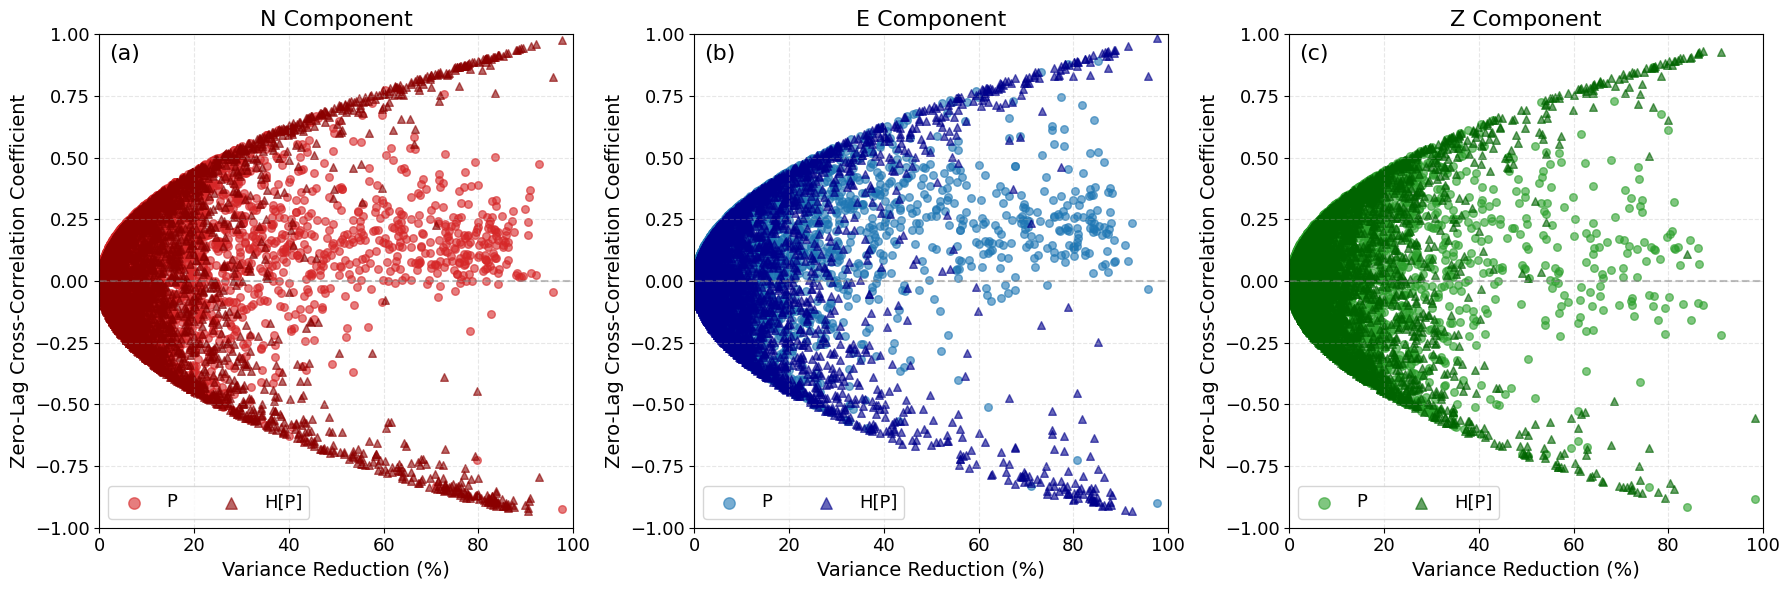

In [14]:
fig = plot_variance_vs_cc(df, components=['N', 'E','Z'], cc_type="zero")

fig.savefig(f'figures/{station}_correlation_vs_variance_reduction_zero.png', dpi=150, bbox_inches='tight')


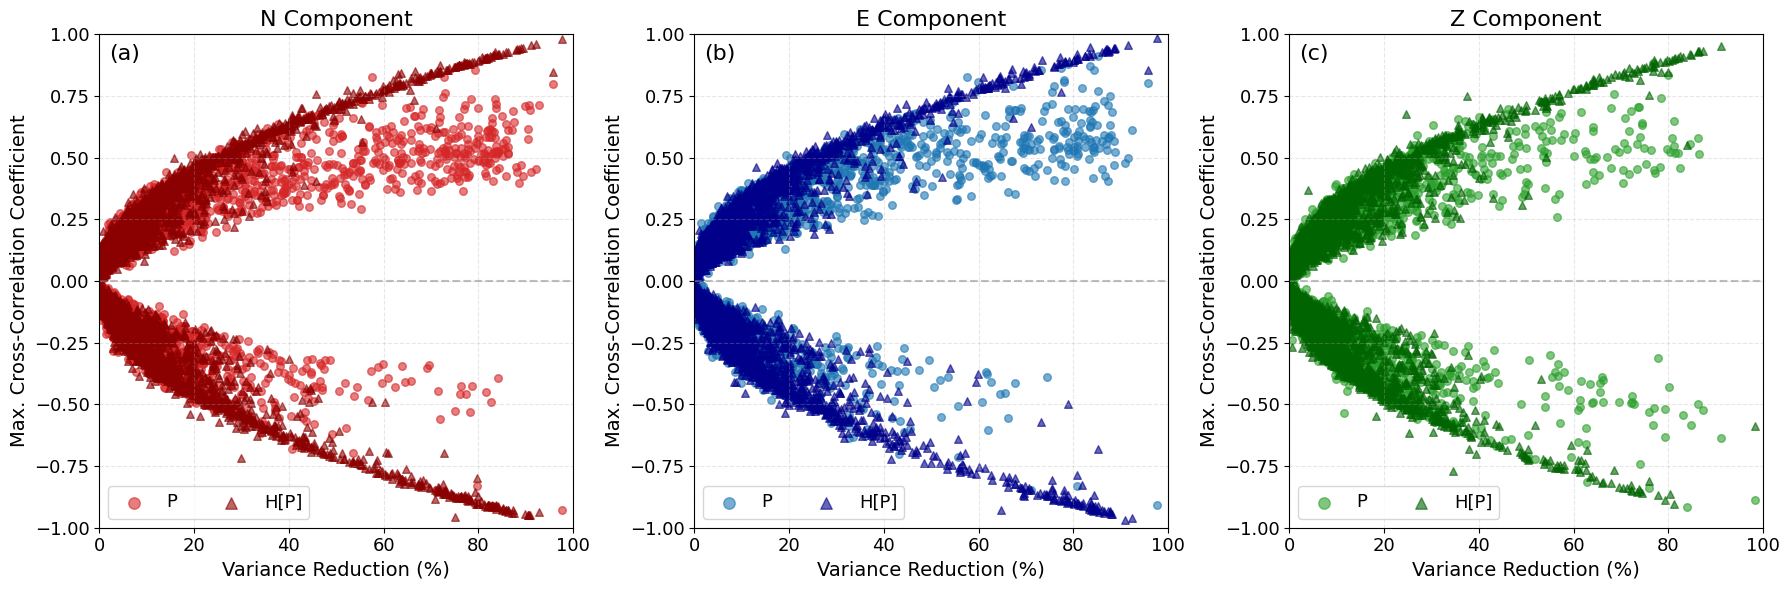

In [15]:
fig = plot_variance_vs_cc(df, components=['N', 'E','Z'], cc_type="max")

fig.savefig(f'figures/{station}_correlation_vs_variance_reduction_max.png', dpi=150, bbox_inches='tight')


## Time Dependancy


In [16]:
def plot_coefficients_time_series(df, components=['N', 'E', 'Z'], figsize=(15, 10), 
                                 save_path=None):
    """
    Plot coefficients over time for all components.
    
    Args:
        df: DataFrame with coefficients data
        components: List of components to plot ['N', 'E', 'Z']
        figsize: Figure size tuple
        save_path: Path to save figure (optional)
    """
    
    if len(df) == 0:
        print("No data found.")
        return
    
    # Sort by start time
    df_sorted = df.sort_values('window_start').copy()
    
    # Compute relative time from first start time
    first_start = df_sorted['window_start'].iloc[0]
    df_sorted['relative_time'] = (df_sorted['window_start'] - first_start).dt.total_seconds() / 86400  # Convert to hours
    
    # Create figure with subplots
    n_components = len(components)
    fig, axes = plt.subplots(n_components, 2, figsize=figsize, sharex=True)
    
    if n_components == 1:
        axes = axes.reshape(1, -1)
    
    colors = ['tab:blue', 'tab:orange', 'tab:red']
    
    # Plot time series for each component
    for i, comp in enumerate(components):
        color = colors[i % len(colors)]
        
        # Pressure coefficients
        p_col = f'P_coef_{comp}'
        p_col_c = 'var_red_' + comp
        if p_col in df_sorted.columns:
            axes[i, 0].scatter(
                df_sorted['relative_time'],
                df_sorted[p_col],
                c=df_sorted[p_col_c], 
                s=3,
                alpha=0.7,
                cmap='viridis',
                vmin=0,
                vmax=100,
                label=f'P-{comp}'
            )
            axes[i, 0].set_title(f'Pressure Coefficients - {comp} Component')
            axes[i, 0].set_ylabel(f"a$_{comp}$", fontsize=14)
            axes[i, 0].grid(True, alpha=0.3)
            axes[i, 0].legend()
            axes[i, 0].axhline(y=0, color='gray', linestyle='-', alpha=0.5)
        
        # Hilbert coefficients
        h_col = f'H_coef_{comp}'
        h_col_c = 'var_red_' + comp
        if h_col in df_sorted.columns:
            axes[i, 1].scatter(
                df_sorted['relative_time'],
                df_sorted[h_col],
                c=df_sorted[h_col_c], 
                s=3,
                alpha=0.7,
                cmap='viridis',
                vmin=0,
                vmax=100,
                label=f'H-{comp}'
            )
            axes[i, 1].set_title(f'Hilbert Coefficients - {comp} Component')
            axes[i, 1].set_ylabel(f"b$_{comp}$", fontsize=14)
            axes[i, 1].grid(True, alpha=0.3)
            axes[i, 1].legend()
            axes[i, 1].axhline(y=0, color='gray', linestyle='-', alpha=0.5)
    
    for i in range(n_components):
        axes[i, 0].set_ylim(-200, 200)
        axes[i, 1].set_ylim(-200, 200)

    # Set x-axis label only on bottom row
    axes[-1, 0].set_xlabel('Time (days)', fontsize=14)
    axes[-1, 1].set_xlabel('Time (days)', fontsize=14)
    
    # Set overall title
    fig.suptitle(f'Coefficients Time Series (Starting from {first_start.strftime("%Y-%m-%d %H:%M")})', fontsize=16)
    
    plt.tight_layout()

    plt.show()
    return fig

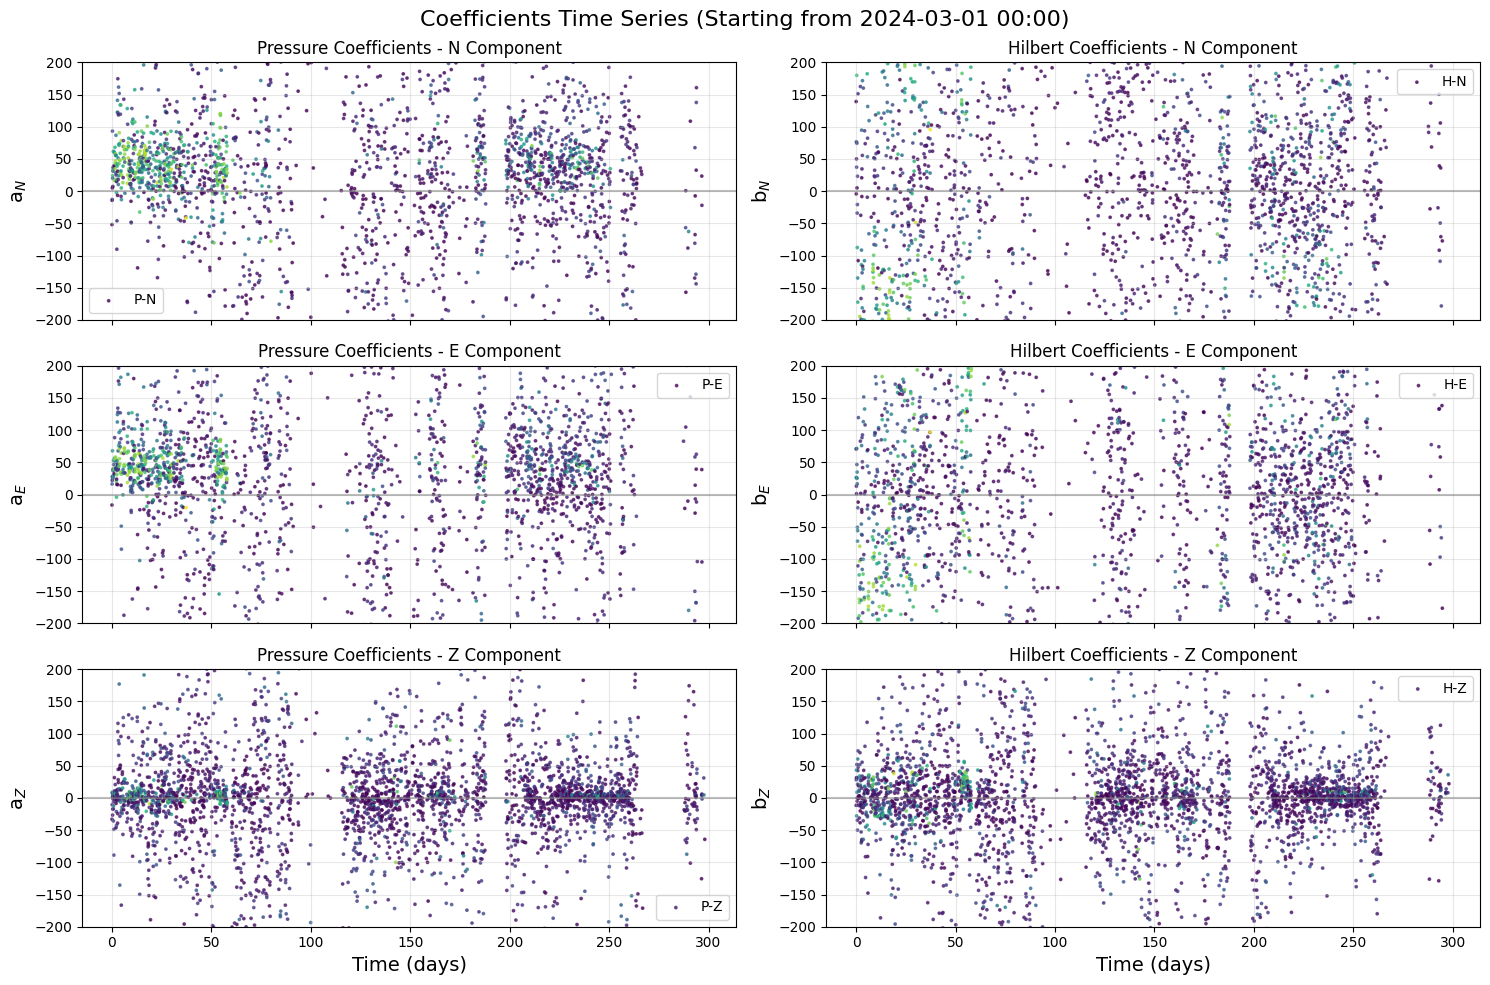

In [17]:
fig = plot_coefficients_time_series(df)

fig.savefig(f'figures/{station}_coefficients_time_series.png', dpi=150, bbox_inches='tight')

In [ ]:
# find good time periods for ROMY

df[(df['var_red_N'] > 75) & (df['var_red_E'] > 75)].sort_values('window_start', ascending=True)

,window_start,window_end,P_coef_N,H_coef_N,var_red_N,P_coef_E,H_coef_E,var_red_E,P_coef_Z,H_coef_Z,...,cc_max_E_H,cc_lag_E_H,cc_zero_Z_P,cc_max_Z_P,cc_lag_Z_P,cc_zero_Z_H,cc_max_Z_H,cc_lag_Z_H,time_hours,date
20,2024-03-02 04:30:00,2024-03-02 07:30:00,16.729655,395.607619,81.03,38.706964,294.923694,75.92,31.559600,18.881893,...,0.869083,20.0,0.152752,0.189035,-100.0,0.088580,0.126134,100.0,28.5,2024-03-02
23,2024-03-02 13:30:00,2024-03-02 16:30:00,34.803181,-318.356002,83.79,41.640246,-162.396858,85.51,9.273957,10.404624,...,-0.935410,-36.0,0.375007,0.429856,-100.0,0.424216,0.556385,100.0,37.5,2024-03-02
27,2024-03-02 16:30:00,2024-03-02 19:30:00,47.138709,-263.447513,85.66,54.106928,-167.812521,78.22,2.722142,3.238354,...,-0.883397,-47.0,0.026423,0.027667,20.0,0.032003,0.063781,100.0,40.5,2024-03-02
28,2024-03-02 18:00:00,2024-03-02 21:00:00,55.780486,-225.091243,82.57,58.200493,-103.345852,82.07,7.825420,34.081759,...,-0.898893,-65.0,0.171732,0.482471,-100.0,0.717806,0.731738,27.0,42.0,2024-03-02
29,2024-03-02 19:30:00,2024-03-02 22:30:00,57.809397,-194.682113,84.91,54.818317,-80.314950,85.26,3.603899,30.481936,...,-0.913856,-70.0,0.076113,0.411795,-100.0,0.642170,0.649870,18.0,43.5,2024-03-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1768,2024-06-19 09:00:00,2024-06-19 12:00:00,-8082.718665,-3260.376972,79.82,-13060.615494,-5337.744184,80.71,NaN,NaN,...,-0.787258,100.0,0.387385,0.676429,-100.0,0.591322,0.645393,52.0,2649.0,2024-06-19
2908,2024-08-29 16:30:00,2024-08-29 19:30:00,46.839061,-66.617148,79.29,59.080526,-78.936734,83.61,-1.327647,-8.331441,...,-0.891579,-96.0,-0.047991,-0.122607,100.0,-0.200346,-0.263456,-100.0,4360.5,2024-08-29
3443,2024-10-02 04:30:00,2024-10-02 07:30:00,32.232352,-134.975810,81.95,37.591709,-93.595238,83.31,-8.886545,0.390184,...,-0.922898,-53.0,-0.314696,-0.329755,40.0,0.015267,-0.191236,100.0,5164.5,2024-10-02
3444,2024-10-02 06:00:00,2024-10-02 09:00:00,38.611722,-125.481434,75.79,41.242225,-103.604244,81.71,-0.189258,-3.148655,...,-0.909824,-48.0,-0.005285,-0.013260,60.0,-0.088627,-0.147299,100.0,5166.0,2024-10-02
